In [10]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config
from torch.optim import Adam
import torch.nn.functional as F

In [11]:
df1 = pd.read_csv('./0530학습용_종목품명.csv')

In [12]:
account_df = df1[['상대계정', '상대계정_new']].drop_duplicates()
num_account = {}
num_account_inverse = {}
for account, account1 in zip(account_df['상대계정'].tolist(), account_df['상대계정_new'].tolist()):
    num_account[account1] = account
    num_account_inverse[account] = account1

In [13]:
df1

,ClassificationCode_invoicee,ClassificationCode_invoicer,품명,상대계정,new,상대계정_new
0,소프트웨어자문개발공급업,도시가스제조및공급업,도시가스 요금,수도광열비,소프트웨어자문개발공급업_도시가스제조및공급업_도시가스 요금,0
1,소프트웨어자문개발공급업,전신전화 부가통신 임대,기가 인터넷 최대 1G (z!22572238130),통신비,소프트웨어자문개발공급업_전신전화 부가통신 임대_기가 인터넷 최대 1G (z!2257...,1
2,소프트웨어자문개발공급업,조명기구,조명기구,소모품비,소프트웨어자문개발공급업_조명기구_조명기구,2
3,소프트웨어자문개발공급업,전신전화 부가통신 임대,일반전화 (000204583123),통신비,소프트웨어자문개발공급업_전신전화 부가통신 임대_일반전화 (000204583123),1
4,소프트웨어자문개발공급업,부가통신,12월 원스토어㈜ 상품 판매 서비스이용료,지급수수료,소프트웨어자문개발공급업_부가통신_12월 원스토어㈜ 상품 판매 서비스이용료,3
...,...,...,...,...,...,...
23514,"전기,전자,반도체건",기타중개업,컨설팅(배기),지급수수료,"전기,전자,반도체건_기타중개업_컨설팅(배기)",3
23515,"전기,전자,반도체건",변리사외,특허등록비용(10-2019-105231),지급수수료,"전기,전자,반도체건_변리사외_특허등록비용(10-2019-105231)",3
23516,"전기,전자,반도체건",생수.음료,생수,복리후생비,"전기,전자,반도체건_생수.음료_생수",9
23517,"전기,전자,반도체건",부품제작및가공,이중관제조설비 및 플랜지성형기 1차중도금,기계장치,"전기,전자,반도체건_부품제작및가공_이중관제조설비 및 플랜지성형기 1차중도금",14


In [14]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [15]:
seed_everything()

In [16]:
class EvalDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, idx):
        text = str(self.df.iloc[idx, 4])
        return text
    
    def __len__(self):
        return len(self.df)

In [17]:
device = torch.device("cuda")
model_config = GPT2Config.from_pretrained('gpt2', num_labels=44)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config = model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

model.to(device)

model.load_state_dict(torch.load("./gpt2_classcode_44_230102_5e5_e4.pth"))
model.eval()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

In [18]:
dataset = EvalDataset(df1)
loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

result = np.empty((0, 44))
for text in loader:
    encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
    padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
    sample = torch.tensor(padded_list)
    sample = sample.to(device)
    outputs = model(sample)
    output = outputs[0].to('cpu').detach().numpy() 
    result = np.vstack((result, output))
    

In [19]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1).reshape(-1,1))
    return e_x / e_x.sum(axis=1).reshape(-1,1) # only difference

In [20]:
new_df = pd.DataFrame(softmax(result))

In [21]:
softmax(result).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [22]:
(result - np.max(result, axis=1).reshape(-1,1)).shape

(23519, 44)

In [23]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.996469,5.467876e-06,0.000013,0.000039,8.927645e-07,2.754736e-06,0.000001,6.277994e-04,0.000004,3.743492e-07,...,1.170018e-08,8.308414e-07,3.338032e-06,2.945695e-04,4.256404e-05,1.450084e-07,5.500889e-06,7.517044e-06,1.248231e-06,9.713680e-06
1,0.000011,9.972246e-01,0.000227,0.000007,1.620375e-06,8.384410e-07,0.000290,1.310050e-05,0.000001,9.371074e-06,...,1.327043e-05,4.290349e-06,1.035671e-06,2.255475e-05,3.253353e-08,3.011352e-07,7.615134e-08,2.329804e-08,3.480409e-05,8.314637e-07
2,0.008703,1.554114e-04,0.281482,0.091424,8.752242e-03,1.572556e-03,0.032094,9.588382e-03,0.000048,2.684461e-04,...,1.974231e-04,2.188304e-05,4.076981e-04,1.114094e-03,2.626555e-05,5.446941e-05,4.140185e-03,2.727646e-04,6.937466e-03,2.944080e-04
3,0.000001,9.996819e-01,0.000202,0.000001,2.434787e-07,9.630934e-08,0.000014,9.178637e-08,0.000001,4.691205e-06,...,4.007350e-07,1.184793e-06,6.591537e-08,2.273618e-06,1.687077e-09,3.190828e-08,6.989763e-09,1.913877e-09,8.641696e-07,1.163803e-07
4,0.000013,1.893656e-03,0.000334,0.994567,2.545633e-06,7.906387e-06,0.001494,4.867810e-04,0.000011,1.923123e-06,...,1.370187e-06,2.603896e-06,9.895198e-05,1.644571e-07,3.020414e-07,2.415334e-05,6.514167e-06,9.272914e-06,8.581818e-06,1.968071e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23514,0.000077,1.845008e-05,0.004352,0.977684,1.468781e-04,1.051652e-03,0.007478,1.676053e-04,0.000506,1.097697e-04,...,9.849100e-06,1.034736e-05,1.634789e-04,6.112594e-06,3.382098e-05,4.493428e-04,5.798589e-04,5.662110e-04,7.543570e-06,3.824799e-05
23515,0.000014,3.109539e-04,0.004629,0.801658,7.182602e-05,3.617020e-04,0.001797,1.902809e-02,0.001503,1.504983e-04,...,4.345196e-04,1.136394e-05,2.283760e-03,7.004938e-05,7.395608e-06,3.562500e-05,9.287161e-05,5.809761e-05,3.622440e-03,6.644254e-04
23516,0.000012,2.673628e-05,0.015963,0.000163,2.480677e-06,1.524195e-06,0.000010,3.725979e-07,0.000010,9.828131e-01,...,2.972027e-06,3.550029e-07,3.042608e-06,1.748318e-06,2.843729e-08,4.766952e-05,1.503183e-04,1.218075e-07,1.132162e-05,2.436202e-06
23517,0.000575,1.398132e-04,0.002320,0.007852,2.086827e-03,3.304501e-04,0.231642,6.809623e-02,0.000304,7.853944e-05,...,9.929476e-05,3.368416e-05,5.021574e-03,8.999568e-04,1.208014e-04,8.086561e-05,8.567884e-04,1.164301e-04,3.436039e-03,2.181200e-03


In [24]:
new_df.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
23514    1.0
23515    1.0
23516    1.0
23517    1.0
23518    1.0
Length: 23519, dtype: float64

In [25]:
(softmax(result)).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [26]:
new_df.to_csv("softmax_gpt2_classcode_44_230102_5e5_e4.csv", index=False)

In [27]:
import pandas as pd

In [28]:
df = pd.read_csv("softmax_gpt2_classcode_44_230102_5e5_e4.csv")

<AxesSubplot:>

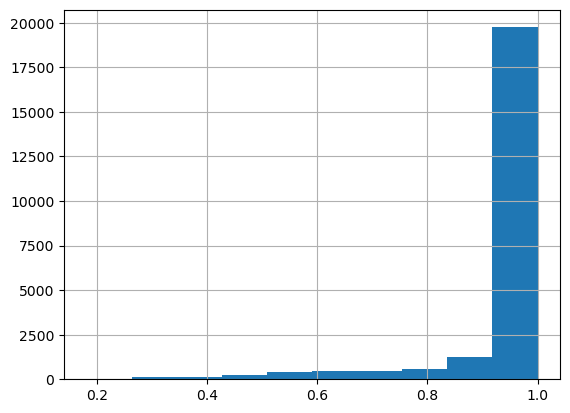

In [29]:
df.max(axis=1).hist()